# Structure learning in decomposable graphical models

Two examples of the particle Gibbs sampler for Bayesian structure learning are shown in this section for both continuous and discrete data.

In [15]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

from trilearn.graph import trajectory
import trilearn.graph.graph as glib
import trilearn.graph.decomposable as dlib
import trilearn.distributions.g_intra_class as gic
import trilearn.auxiliary_functions as aux
from trilearn.distributions import discrete_dec_log_linear as loglin
from trilearn import pgibbs
sns.set_style("whitegrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Discrete log-linear models

The first two rows (i.e. index 0 and 1), of the file should specify the labels and the levels of the corresponding variables. 

#### Czech auto workers data

In [16]:
aw_df = pd.read_csv("sample_data/czech_autoworkers.csv", header=[0, 1]) 

In [17]:
aw_df.shape

(1841, 6)

In [18]:
np.random.seed(1)
aw_graph_traj= pgibbs.sample_trajectory_loglin(dataframe=aw_df, n_particles=100, n_samples=1000, reset_cache=False)

Particle Gibbs samples: 100%|██████████| 1000/1000 [01:38<00:00, 10.11it/s]


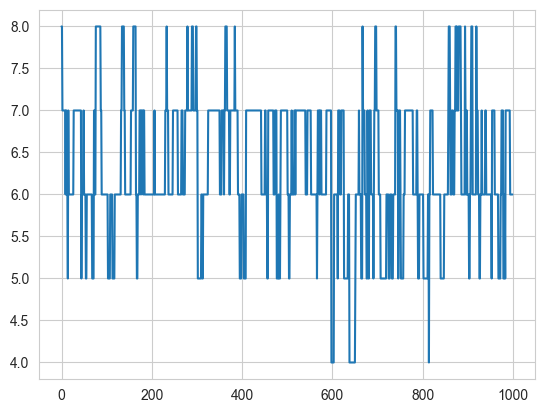

In [19]:
aw_graph_traj.size().plot();
plt.show()

In [20]:
tr = aw_graph_traj.graph_diff_trajectory_df(labels=[x[0] for x in aw_df.columns])

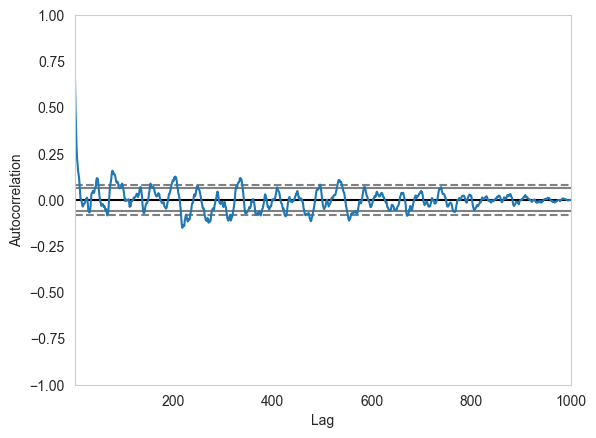

In [21]:
autocorrelation_plot(aw_graph_traj.size());
plt.show()

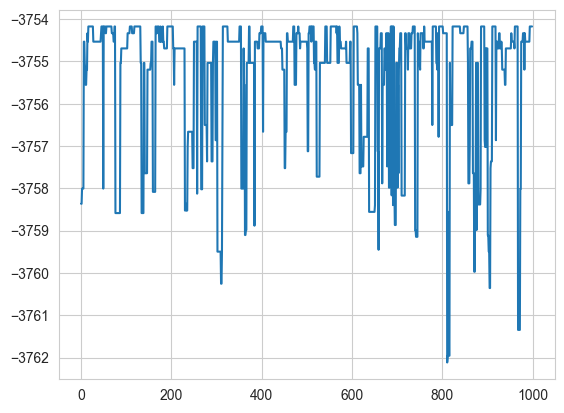

In [22]:
aw_graph_traj.log_likelihood().plot();
plt.show()

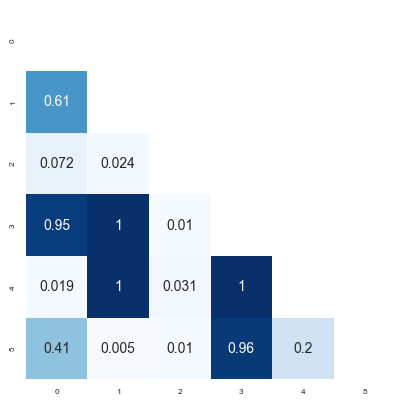

In [23]:
aux.plot_heatmap(aw_graph_traj.empirical_distribution().heatmap(), annot=True)
plt.show()

In [24]:
aw_top = aw_graph_traj.empirical_distribution().mode(5)
print("Probability\tEdge list: ")
for graph, prob in aw_top:
    print(str(prob)+ "\t\t"  + str(sorted(list(graph.edges()))))

Probability	Edge list: 
0.23500000000000018		[(1, 0), (1, 3), (1, 4), (3, 0), (3, 4), (3, 5)]
0.19600000000000015		[(0, 1), (0, 3), (0, 5), (1, 3), (1, 4), (3, 4), (3, 5)]
0.11600000000000009		[(0, 5), (1, 3), (1, 4), (3, 0), (3, 4), (3, 5)]
0.09300000000000007		[(0, 3), (1, 4), (3, 1), (3, 4), (3, 5)]
0.08300000000000006		[(0, 1), (0, 3), (1, 3), (1, 4), (3, 4), (3, 5), (4, 5)]


In [25]:
aw_mapgraph = aw_graph_traj.empirical_distribution().mode(1)[0][0]

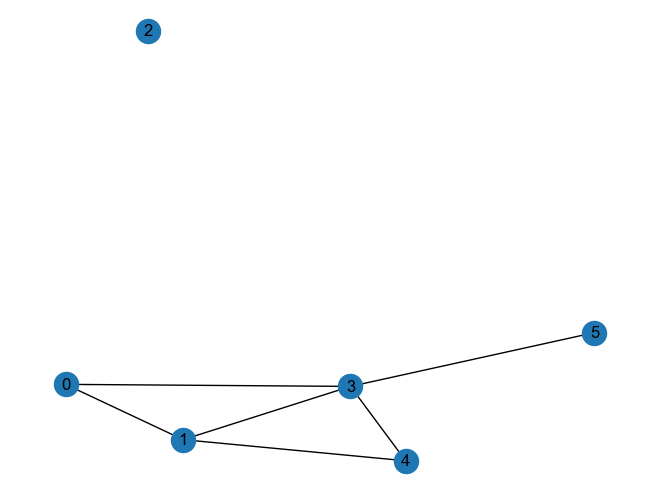

In [26]:
nx.draw(aw_mapgraph, with_labels=True)
plt.show()

## Gaussian graphical models (GGMs)

#### Simualted AR(1-5)-model

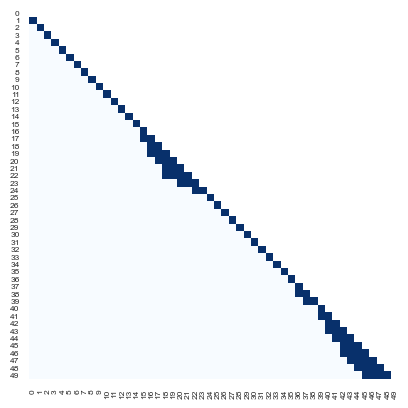

In [27]:
np.random.seed(2) # generates same data as in the paper
ar_graph = dlib.sample_random_AR_graph(n_dim=50, max_bandwidth=5)
aux.plot_heatmap(nx.to_numpy_array(ar_graph))
ar_cov_mat = gic.cov_matrix(ar_graph, 0.9, 1.0)
ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(50), ar_cov_mat, 100))

In [28]:
ar_df.shape

(100, 50)

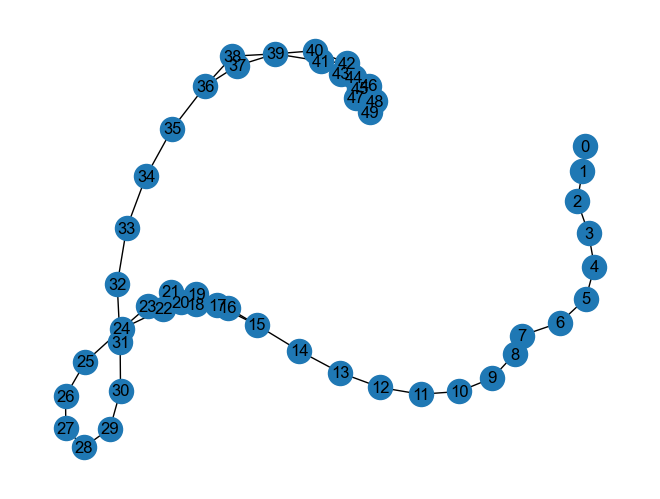

In [29]:
nx.draw(ar_graph, with_labels=True)

In [30]:
np.random.seed(1)

In [31]:
ar_graph_traj_seed1 = pgibbs.sample_trajectory_ggm(dataframe=ar_df, n_particles=50, alpha=0.5, beta=0.8, radius=5, n_samples=100, reset_cache=True)

Particle Gibbs samples: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


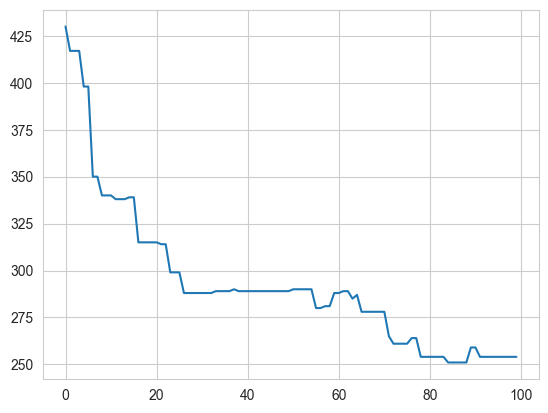

In [32]:
ar_graph_traj_seed1.size().plot();

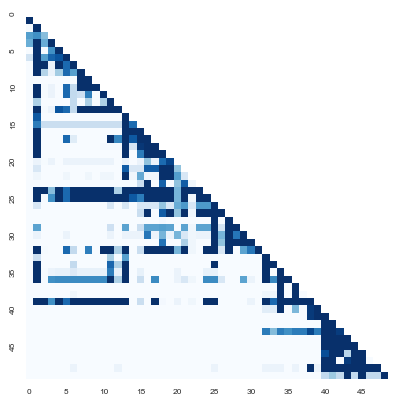

In [33]:
aux.plot_heatmap(ar_graph_traj_seed1.empirical_distribution(0).heatmap(), xticklabels=5, yticklabels=5 )

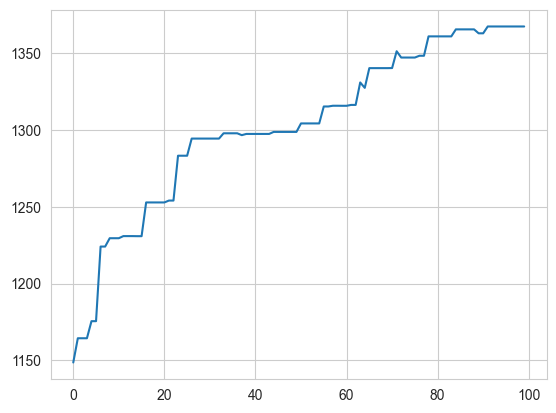

In [34]:
ar_graph_traj_seed1.logl =[]
ar_graph_traj_seed1.log_likelihood(0).plot();

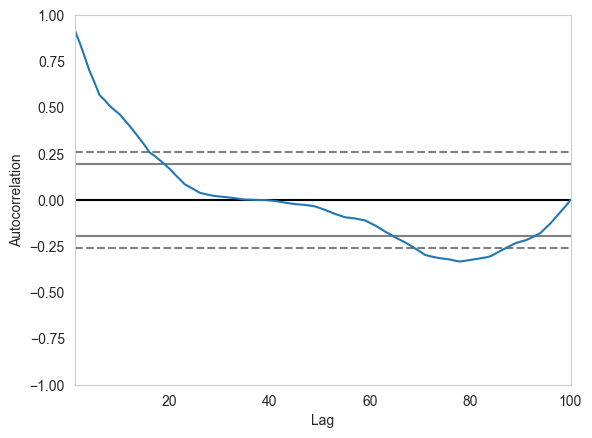

In [35]:
autocorrelation_plot(ar_graph_traj_seed1.size());

## Simulated 15 nodes log-linear model

In [36]:
loglin_graph = nx.Graph()
loglin_graph.add_nodes_from(range(15))
loglin_graph.add_edges_from([(0, 11), (0, 7), (1, 8), (1, 6), (2, 4), (3, 8), (3, 9),
                             (3, 10), (3, 4), (3, 6), (4, 6), (4, 8), (4, 9), (4, 10),
                             (5, 10), (5, 6), (6, 8), (6, 9), (6, 10), (7, 11), (8, 9),
                             (8, 10), (8, 11), (9, 10), (10, 11), (12, 13)])

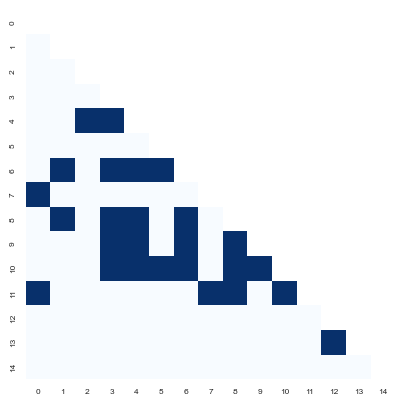

In [37]:
aux.plot_heatmap(nx.to_numpy_array(loglin_graph))

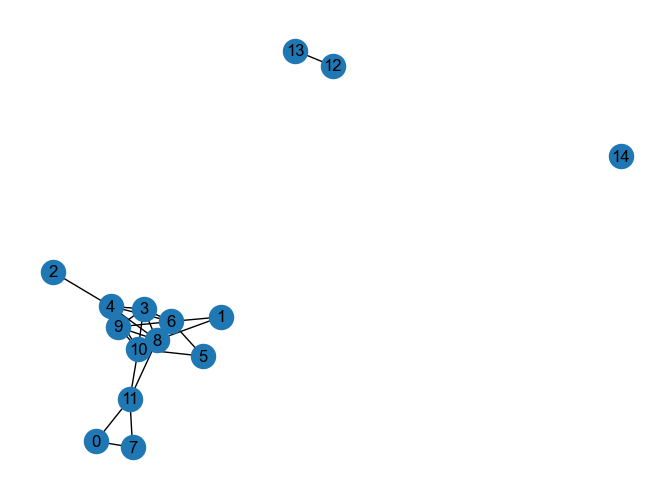

In [38]:
nx.draw(loglin_graph, with_labels=True)

In [39]:
np.random.seed(2)
levels = np.array([range(2)] * loglin_graph.order())
table = loglin.sample_prob_table(loglin_graph, levels, 1.0)

In [40]:
np.random.seed(332312)
loglin_df = pd.DataFrame(loglin.sample(table, 1000))
loglin_df.columns = [list(range(loglin_graph.order())), [len(l) for l in levels]]

In [41]:
#loglin_df = pd.read_csv("sample_data/discrete_loglin_p15.csv", header=[0, 1]) 

In [42]:
np.random.seed(1)
loglin_graph_traj = pgibbs.sample_trajectory_loglin(dataframe=loglin_df, alpha=0.5, beta=0.5, n_particles=50, n_samples=1000, 
                                                    reset_cache=True)

Particle Gibbs samples: 100%|██████████| 1000/1000 [03:00<00:00,  5.55it/s]


In [43]:
trajdf = loglin_graph_traj.graph_diff_trajectory_df(labels=[x[0] for x in loglin_df.columns])

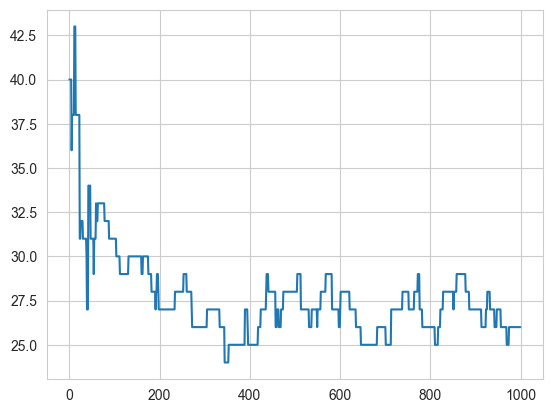

In [44]:
loglin_graph_traj.size().plot();

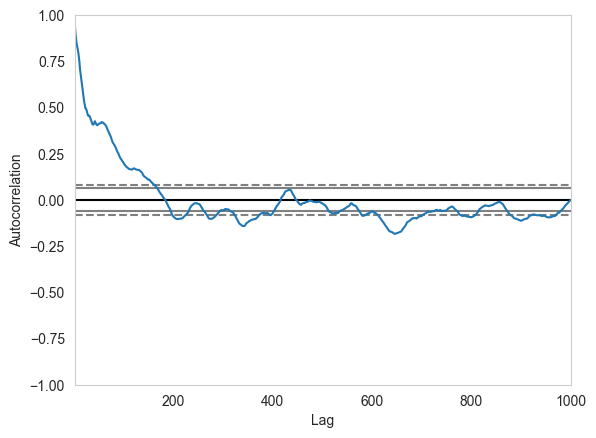

In [45]:
autocorrelation_plot(loglin_graph_traj.size());

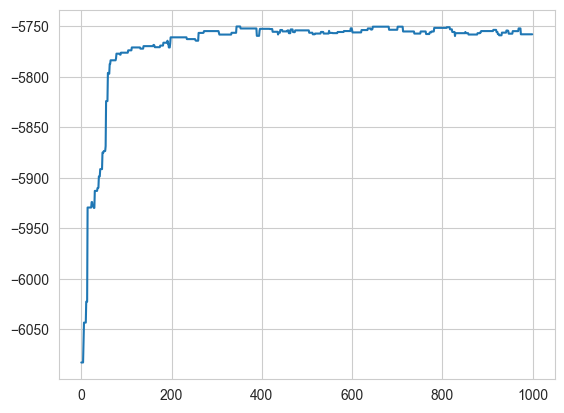

In [46]:
loglin_graph_traj.log_likelihood().plot();

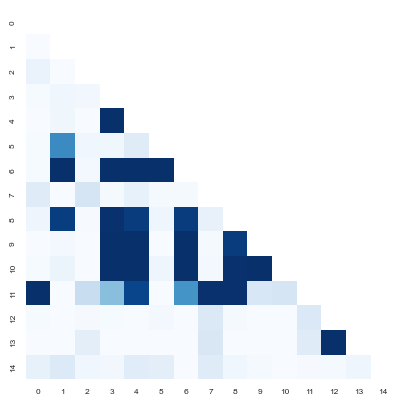

In [47]:
aux.plot_heatmap(loglin_graph_traj.empirical_distribution(5).heatmap())

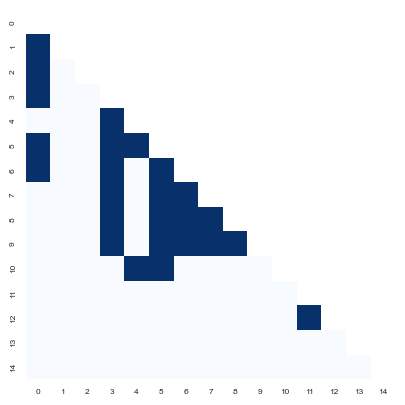

In [48]:
loglin_mapgraph = loglin_graph_traj.empirical_distribution().mode(1)[0][0]
aux.plot_heatmap(nx.to_numpy_array(loglin_mapgraph))

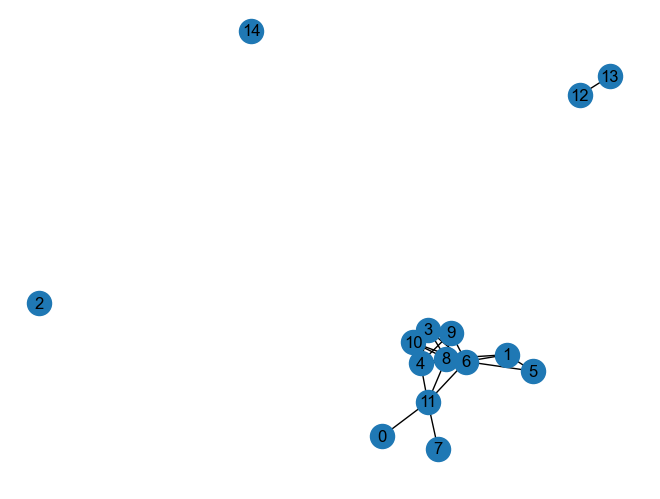

In [49]:
nx.draw(loglin_mapgraph, with_labels=True)